In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
class EfficientNetwork(pl.LightningModule):
    def __init__(self, n_classes, model = 'efficientnet-b0', channels = 3, eta = 0.001, **kwargs):
        super().__init__()
        self.model = EfficientNet.from_pretrained(model, num_classes=n_classes, in_channels=channels)
    
    def forward(self, x):
        return self.model(x)


class ConvolutionalNetwork(nn.Module):
    def __init__(self, n_classes, image_resize, channels = 3, n1 = 5, n2 = 10, n3 = 20, n_inside = 512):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=n1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(n1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(n2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(n3)
        self.act3 = nn.ReLU()

        self.flat_size = n3 * (image_resize//4)**2
        self.fc1 = nn.Linear(self.flat_size, n_inside)
        self.fc1_act = nn.ReLU()
        self.fc2 = nn.Linear(n_inside, n_classes)

    def forward(self, x):
        y1 = self.pool1(self.act1(self.bn1(self.conv1(x))))
        y2 = self.pool2(self.act2(self.bn2(self.conv2(y1))))
        y3 = self.act3(self.bn3(self.conv3(y2)))
        y_flat = y3.view(-1, self.flat_size)
        y = self.fc2(self.fc1_act(self.fc1(y_flat)))
        return y

def normalize(image_resize, path):
    transform = transforms.Compose([
        transforms.Resize(image_resize),
        transforms.ToTensor()
    ])
    dataset = ImageFolder(path, transform=transform)
    loader = DataLoader(dataset, batch_size=2)
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images**2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels
    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment**2)
    return mean.numpy(), std.numpy()

def createDataLoader(image_folder_path, batch_size=64, image_resize=(64,64), normalize_calc = True, mean = [0.5, 0.5, 0.5], std = [0.25, 0.25, 0.25], absolute_path = False, shuffle = True):
    if normalize_calc:
        mean, std = normalize(image_resize, image_folder_path)
    if not absolute_path:
        image_folder_path = os.path.join(os.getcwd(), image_folder_path)
    dataset = ImageFolder(image_folder_path, transform=transforms.Compose([transforms.Resize(image_resize), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

def createSplitDataLoader(image_folder_path, batch_size=64, image_resize=(64,64), normalize_calc = True, mean = [0.5, 0.5, 0.5], std = [0.25, 0.25, 0.25], absolute_path = False, shuffle_test = True, test_size = 0.2, validation_size = 0.05):
    if normalize_calc:
        mean, std = normalize(image_resize, image_folder_path)
    if not absolute_path:
        image_folder_path = os.path.join(os.getcwd(), image_folder_path)
    dataset = ImageFolder(image_folder_path, transform=transforms.Compose([transforms.Resize(image_resize), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]))
    test_size = int(test_size * len(dataset))
    train_size = len(dataset) - test_size
    validation_size = int(validation_size * train_size)
    train_size = train_size - validation_size
    train_dataset, test_dataset, validation_dataset = random_split(dataset,
                                                                   [train_size, test_size, validation_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, validation_loader

class ImageClassifier():
    def __init__(self, model=None, n_classes=0, classes=[], n_hidden=512,
                 device="cuda" if torch.cuda.is_available() else "cpu", image_folder_path=None, absolute_path=False,
                 batch_size=64, shuffle_test=False, test_size=0.2, image_resize=(64, 64), validation_size=0.05, mean = [0.5, 0.5, 0.5], std = [0.25, 0.25, 0.25], normalize_calc = True):
        if len(classes) > 0:
            self.n_classes = len(classes)
        elif len(classes) == 0 and n_classes > 0:
            self.n_classes = n_classes
        else:
            raise Exception('Классы не заданы')
        if image_folder_path:
            if normalize_calc:
                mean, std = self.normalize(image_resize, image_folder_path)
            if absolute_path:
                dataset = self.load_folder(image_resize, image_folder_path, mean, std)
            else:
                dataset = self.load_folder(image_resize, os.path.join(os.getcwd(), image_folder_path), mean, std)
            self.train_loader, self.test_loader, self.validation_loader = self.create_dataloaders(dataset, batch_size,
                                                                                                  shuffle_test,
                                                                                                  test_size,
                                                                                                  validation_size)
        else:
            self.train_loader, self.test_loader, self.validation_loader = None, None, None
        self.device = device
        self.classes = classes
        if not model:
            self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
            for param in self.model.parameters():
                param.require = False
            self.model.fc = nn.Linear(n_hidden, self.n_classes)
        else:
            self.model = model
    
    def normalize(self, image_resize, path):
        transform = transforms.Compose([
            transforms.Resize(image_resize),
            transforms.ToTensor()
        ])
        dataset = ImageFolder(path, transform=transform)
        loader = DataLoader(dataset, batch_size=2)
        cnt = 0
        fst_moment = torch.empty(3)
        snd_moment = torch.empty(3)
        for images, _ in loader:
            b, c, h, w = images.shape
            nb_pixels = b * h * w
            sum_ = torch.sum(images, dim=[0, 2, 3])
            sum_of_square = torch.sum(images**2, dim=[0, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
            cnt += nb_pixels
        mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment**2)
        return mean.numpy(), std.numpy()
        

    def load_folder(self, image_resize, path, mean, std):
        transform = transforms.Compose([
            transforms.Resize(image_resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        dataset = ImageFolder(path, transform=transform)
        return dataset

    def create_dataloaders(self, dataset, batch_size, shuffle_test, test_size, validation_size):
        test_size = int(test_size * len(dataset))
        train_size = len(dataset) - test_size
        validation_size = int(validation_size * train_size)
        train_size = train_size - validation_size
        train_dataset, test_dataset, validation_dataset = random_split(dataset,
                                                                       [train_size, test_size, validation_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test)
        validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, test_loader, validation_loader

    def fit(self, train_loader=None, epochs=10, learning_rate=0.001, validation_loader=None, validation=True):
        if not train_loader:
            train_loader = self.train_loader
            if not train_loader:
                raise Exception('Обучающие данные не заданы')
        if not validation_loader:
            validation_loader = self.validation_loader
            if not validation_loader:
                validation = False
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.model.train()
        self.model.to(self.device)
        print('Обучение модели на ', self.device)

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in tqdm(enumerate(train_loader)):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print("Эпоха: {}, Функция потерь: {} ".format(epoch, running_loss / len(train_loader)))

            if validation:
                self.model.eval()
                train_score = self.accuracy_score(train_loader, size = 50)
                print("Тренировка: ", train_score)
                validation_score = self.accuracy_score(validation_loader)
                print("Валидация: ", validation_score)
                self.model.train()

    def accuracy_score(self, test_loader=None, size = None):
        if not test_loader:
            test_loader = self.test_loader
            if not test_loader:
                raise Exception('Тестовые данные не заданы')
        correct = 0
        total = 0
        with torch.no_grad():
            self.model.eval()
            for idx, data in enumerate(test_loader):
                if size:
                    if idx >= size:
                        break
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    def save(self, path='model.pt'):
        torch.save(self.model.state_dict(), path)

    def load(self, path='model.pt'):
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)

    def plot_images(self, images, labels, n):
        plt.figure(figsize=(12, 12))
        for i, image in enumerate(images[:n]):
            plt.subplot(n, n, i + 1)
            image = image / 2 + 0.5
            plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print("Реальные метки: ", ' '.join('%5s' % self.classes[label] for label in labels[:n]))

    def predict(self, test_loader=None, size=4):
        if self.n_classes == 0:
            raise Exception('Метки классов не заданы, невозможно выполнить предсказание')
        if not test_loader:
            test_loader = self.test_loader
            if not test_loader:
                raise Exception('Тестовые данные не заданы')
        images, labels = next(iter(test_loader))
        self.plot_images(images, labels, size)
        result = self.model(images.to(self.device))
        _, prediction = torch.max(result, 1)
        print_res = ''
        for pred in prediction[:size]:
            print_res += (self.classes[pred] + " ")
        print("Предсказание: ", print_res)




In [3]:
clf_classes = ['Cat', 'Dog']
clf_model = ImageClassifier(classes=clf_classes, image_folder_path='dataset', batch_size=128, mean = [0.48830763, 0.4552706 , 0.41702238], std = [0.2525181 , 0.24572441, 0.24856547], normalize_calc=False)

In [4]:
epochs = 10

clf_model.fit(epochs = epochs)

Обучение модели на  cuda


149it [02:37,  1.06s/it]


Эпоха: 0, Функция потерь: 0.6386025525979547 
Тренировка:  0.724375
Валидация:  0.7447447447447447


149it [00:54,  2.75it/s]


Эпоха: 1, Функция потерь: 0.4970125926020961 
Тренировка:  0.785625
Валидация:  0.7627627627627628


149it [00:54,  2.72it/s]


Эпоха: 2, Функция потерь: 0.4357859760322827 
Тренировка:  0.816875
Валидация:  0.7937937937937938


149it [00:55,  2.68it/s]


Эпоха: 3, Функция потерь: 0.39675859396889707 
Тренировка:  0.8459375
Валидация:  0.8028028028028028


149it [00:53,  2.76it/s]


Эпоха: 4, Функция потерь: 0.3673286662005738 
Тренировка:  0.858125
Валидация:  0.8208208208208209


149it [00:54,  2.75it/s]


Эпоха: 5, Функция потерь: 0.3403141232544944 
Тренировка:  0.8659375
Валидация:  0.8308308308308309


149it [01:57,  1.27it/s]


Эпоха: 6, Функция потерь: 0.3177840019632506 
Тренировка:  0.8703125
Валидация:  0.8408408408408409


149it [00:53,  2.76it/s]


Эпоха: 7, Функция потерь: 0.30305397250508304 
Тренировка:  0.88390625
Валидация:  0.8488488488488488


149it [01:28,  1.68it/s]


Эпоха: 8, Функция потерь: 0.2851406991881812 
Тренировка:  0.89375
Валидация:  0.8558558558558559


149it [01:02,  2.39it/s]


Эпоха: 9, Функция потерь: 0.26943819204832886 
Тренировка:  0.89953125
Валидация:  0.8588588588588588


In [5]:
clf_model.save('model_cats_dogs.pt')

In [6]:
score = clf_model.accuracy_score()
print("Точность на тестовом датасете: ", score)

Точность на тестовом датасете:  0.8459691938387678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальные метки:    Dog   Dog   Dog   Cat   Dog   Dog
Предсказание:  Dog Dog Dog Cat Dog Dog 


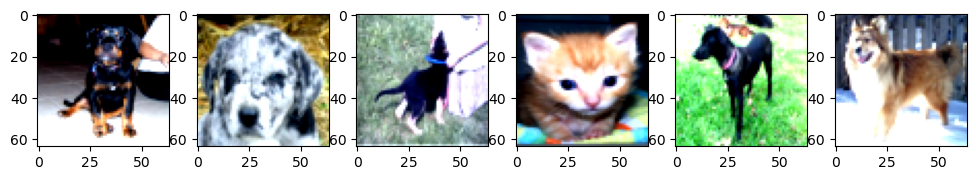

In [7]:
clf_model.predict(size= 6)

In [8]:
model_dgt = ConvolutionalNetwork(n_classes=10, image_resize=28)

In [9]:
dgt_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dgt_model = ImageClassifier(model = model_dgt, classes=dgt_classes, image_folder_path='mnist', batch_size=64, image_resize=(28, 28), normalize_calc=False)

In [10]:
epochs = 10

dgt_model.fit(epochs = epochs)

Обучение модели на  cuda


713it [03:16,  3.63it/s]


Эпоха: 0, Функция потерь: 1.873109317762153 
Тренировка:  0.7171875
Валидация:  0.71375


713it [00:20, 35.23it/s]


Эпоха: 1, Функция потерь: 1.0876058371839483 
Тренировка:  0.825
Валидация:  0.8341666666666666


713it [00:21, 33.63it/s]


Эпоха: 2, Функция потерь: 0.6794370236854901 
Тренировка:  0.8703125
Валидация:  0.8725


713it [00:21, 33.06it/s]


Эпоха: 3, Функция потерь: 0.4929001248568338 
Тренировка:  0.89625
Валидация:  0.8916666666666667


713it [00:21, 33.37it/s]


Эпоха: 4, Функция потерь: 0.39210302293885807 
Тренировка:  0.9078125
Валидация:  0.9041666666666667


713it [00:21, 33.23it/s]


Эпоха: 5, Функция потерь: 0.33199661270013864 
Тренировка:  0.91625
Валидация:  0.9195833333333333


713it [00:21, 32.79it/s]


Эпоха: 6, Функция потерь: 0.2914199421043817 
Тренировка:  0.928125
Валидация:  0.9266666666666666


713it [00:21, 32.45it/s]


Эпоха: 7, Функция потерь: 0.2619909064695344 
Тренировка:  0.9240625
Валидация:  0.9345833333333333


713it [00:22, 32.18it/s]


Эпоха: 8, Функция потерь: 0.23969126154170967 
Тренировка:  0.9296875
Валидация:  0.9358333333333333


713it [00:30, 23.46it/s]


Эпоха: 9, Функция потерь: 0.22147140836899612 
Тренировка:  0.9396875
Валидация:  0.9383333333333334


In [11]:
score = dgt_model.accuracy_score()
print("Точность на тестовом датасете: ", score)

Точность на тестовом датасете:  0.94075


In [12]:
dgt_model.save('model_mnist.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальные метки:      7     2     6     5     8     5
Предсказание:  7 2 6 5 8 5 


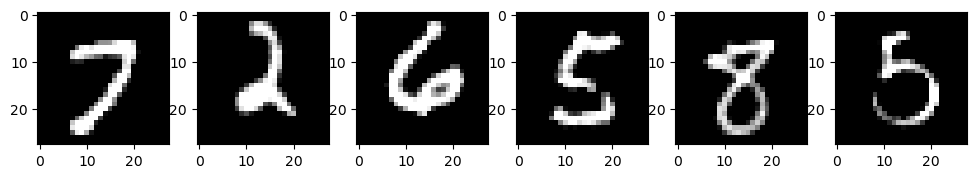

In [13]:
dgt_model.predict(size= 6)

In [29]:
print(normalize((128, 128), os.path.join(os.getcwd(), 'data')))

(array([0.5288455 , 0.5339674 , 0.53614086], dtype=float32), array([0.309866  , 0.30023178, 0.31286213], dtype=float32))


In [14]:
vcl_classes = ['aircraft', 'boat', 'bus', 'car', 'moto', 'truck']
vcl_model = ImageClassifier(classes=vcl_classes, image_folder_path='data', batch_size=128, image_resize=(128, 128), normalize_calc=False, mean=[0.5288455 , 0.5339674 , 0.53614086], std=[0.309866  , 0.30023178, 0.31286213])

In [15]:
epochs = 25

vcl_model.fit(epochs = epochs)

Обучение модели на  cuda


13it [00:19,  1.48s/it]


Эпоха: 0, Функция потерь: 1.9204218479303212 
Тренировка:  0.30681133212778783
Валидация:  0.3333333333333333


13it [00:11,  1.17it/s]


Эпоха: 1, Функция потерь: 1.6731539781276996 
Тренировка:  0.4128993369499699
Валидация:  0.4482758620689655


13it [00:11,  1.14it/s]


Эпоха: 2, Функция потерь: 1.5157813750780547 
Тренировка:  0.47860156720916214
Валидация:  0.5172413793103449


13it [00:11,  1.14it/s]


Эпоха: 3, Функция потерь: 1.3977526701413667 
Тренировка:  0.5521398432790838
Валидация:  0.5287356321839081


13it [00:11,  1.09it/s]


Эпоха: 4, Функция потерь: 1.290643389408405 
Тренировка:  0.6094032549728752
Валидация:  0.5747126436781609


13it [00:11,  1.14it/s]


Эпоха: 5, Функция потерь: 1.2027684083351722 
Тренировка:  0.6503918022905365
Валидация:  0.632183908045977


13it [00:11,  1.13it/s]


Эпоха: 6, Функция потерь: 1.1242940059074988 
Тренировка:  0.6889692585895117
Валидация:  0.6896551724137931


13it [00:11,  1.12it/s]


Эпоха: 7, Функция потерь: 1.0486527406252348 
Тренировка:  0.7221217600964437
Валидация:  0.735632183908046


13it [00:11,  1.10it/s]


Эпоха: 8, Функция потерь: 0.9947863633816059 
Тренировка:  0.7510548523206751
Валидация:  0.7586206896551724


13it [00:11,  1.10it/s]


Эпоха: 9, Функция потерь: 0.9343878810222332 
Тренировка:  0.7727546714888487
Валидация:  0.7816091954022989


13it [00:11,  1.09it/s]


Эпоха: 10, Функция потерь: 0.8913433047441336 
Тренировка:  0.781796262808921
Валидация:  0.7931034482758621


13it [00:13,  1.06s/it]


Эпоха: 11, Функция потерь: 0.8435144424438477 
Тренировка:  0.8010849909584087
Валидация:  0.8045977011494253


13it [00:12,  1.08it/s]


Эпоха: 12, Функция потерь: 0.8020664499356196 
Тренировка:  0.8137432188065099
Валидация:  0.8045977011494253


13it [00:11,  1.10it/s]


Эпоха: 13, Функция потерь: 0.7662626504898071 
Тренировка:  0.8276069921639542
Валидация:  0.8045977011494253


13it [00:11,  1.10it/s]


Эпоха: 14, Функция потерь: 0.7273849157186655 
Тренировка:  0.8330319469559976
Валидация:  0.8160919540229885


13it [00:11,  1.10it/s]


Эпоха: 15, Функция потерь: 0.7077792470271771 
Тренировка:  0.8420735382760699
Валидация:  0.8160919540229885


13it [00:11,  1.11it/s]


Эпоха: 16, Функция потерь: 0.6723066889322721 
Тренировка:  0.8474984930681133
Валидация:  0.8160919540229885


13it [00:11,  1.12it/s]


Эпоха: 17, Функция потерь: 0.6456153622040381 
Тренировка:  0.8577456298975287
Валидация:  0.8160919540229885


13it [00:11,  1.11it/s]


Эпоха: 18, Функция потерь: 0.6165195474257836 
Тренировка:  0.8631705846895721
Валидация:  0.8390804597701149


13it [00:11,  1.10it/s]


Эпоха: 19, Функция потерь: 0.6067370680662302 
Тренировка:  0.8673899939722725
Валидация:  0.8505747126436781


13it [00:11,  1.10it/s]


Эпоха: 20, Функция потерь: 0.5786838577343867 
Тренировка:  0.8752260397830018
Валидация:  0.8620689655172413


13it [00:12,  1.07it/s]


Эпоха: 21, Функция потерь: 0.5611732051922724 
Тренировка:  0.8818565400843882
Валидация:  0.8620689655172413


13it [00:12,  1.06it/s]


Эпоха: 22, Функция потерь: 0.5426927185975589 
Тренировка:  0.8872814948764316
Валидация:  0.8735632183908046


13it [00:11,  1.11it/s]


Эпоха: 23, Функция потерь: 0.5268491919224079 
Тренировка:  0.891500904159132
Валидация:  0.8735632183908046


13it [00:11,  1.09it/s]


Эпоха: 24, Функция потерь: 0.5071570391838367 
Тренировка:  0.8945147679324894
Валидация:  0.8735632183908046


In [16]:
vcl_model.save('model_vcl.pt')

In [17]:
score = vcl_model.accuracy_score()
print("Точность на тестовом датасете: ", score)

Точность на тестовом датасете:  0.8119266055045872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальные метки:    bus   car   car   bus aircraft   car aircraft   car
Предсказание:  bus car car bus aircraft boat boat car 


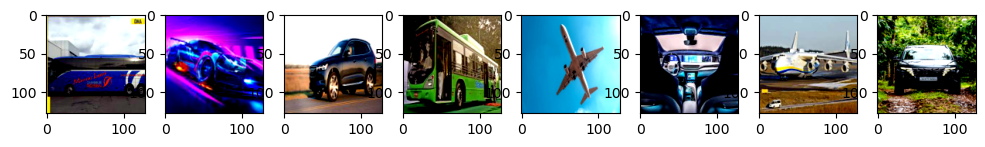

In [19]:
vcl_model.predict(size= 8)

In [20]:
test_loader = createDataLoader(image_folder_path='test_vcl', batch_size=32, image_resize=(128, 128), normalize_calc=False, mean=[0.5288455 , 0.5339674 , 0.53614086], std=[0.309866  , 0.30023178, 0.31286213])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Реальные метки:   boat aircraft
Предсказание:  boat aircraft 


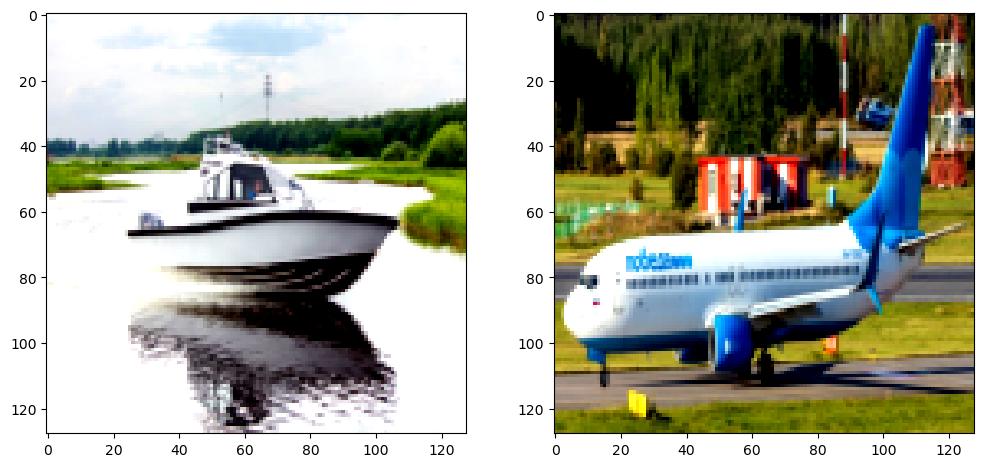

In [31]:
vcl_model.predict(test_loader, size= 2)